In [60]:
# ============================================================
# IMPORTS AND CONFIGURATION
# ============================================================

import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from urllib.parse import urlparse
from scipy import stats

# Visualization settings
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 11

# Color scheme for EU vs US
COLORS = {
    'EU': '#003399',  # EU blue
    'US': '#B22234'   # US red
}

print("✅ Libraries loaded successfully")
print(f"📊 Pandas version: {pd.__version__}")
print(f"🔢 NumPy version: {np.__version__}")

✅ Libraries loaded successfully
📊 Pandas version: 2.3.3
🔢 NumPy version: 1.26.4


## 📂 Data Loading

Load data from two different collection runs:
- **EU Data**: Collected from a European IP address
- **US Data**: Collected from a US IP address

⚠️ **Note**: Update the file paths below to point to your EU and US data files.

In [61]:
def load_jsonl(file_path: str) -> list:
    """
    Load JSONL (newline-delimited JSON) file.
    
    Args:
        file_path: Path to the JSONL file
        
    Returns:
        List of parsed JSON records
    """
    records = []
    with open(file_path, 'r', encoding='utf-8') as f:
        for line in f:
            line = line.strip()
            if line:
                try:
                    records.append(json.loads(line))
                except json.JSONDecodeError as e:
                    print(f"Warning: Skipping malformed line: {e}")
    return records

# ============================================================
# UPDATE THESE PATHS TO YOUR DATA FILES
# ============================================================

# Example paths - update these!
EU_DATA_PATH = '../data/examples/tranco_QWJY4-Germany.json'  # Replace with EU data path
US_DATA_PATH = '../data/examples/tranco_QWJY4-US.json'  # Replace with US data path

# Check if files exist
eu_path = Path(EU_DATA_PATH)
us_path = Path(US_DATA_PATH)

if not eu_path.exists():
    print(f"⚠️  EU data file not found: {EU_DATA_PATH}")
    print("   Please update EU_DATA_PATH to point to your EU dataset")
else:
    print(f"✅ EU data found: {EU_DATA_PATH}")

if not us_path.exists():
    print(f"⚠️  US data file not found: {US_DATA_PATH}")
    print("   Please update US_DATA_PATH to point to your US dataset")
else:
    print(f"✅ US data found: {US_DATA_PATH}")

✅ EU data found: ../data/examples/tranco_QWJY4-Germany.json
✅ US data found: ../data/examples/tranco_QWJY4-US.json


In [62]:
# Load both datasets
print("Loading EU data...")
eu_records = load_jsonl(EU_DATA_PATH)
print(f"  Loaded {len(eu_records)} EU records")

print("\nLoading US data...")
us_records = load_jsonl(US_DATA_PATH)
print(f"  Loaded {len(us_records)} US records")

# Check for overlapping URLs
eu_urls = set(r.get('url', '') for r in eu_records)
us_urls = set(r.get('url', '') for r in us_records)
common_urls = eu_urls & us_urls

print(f"\n📊 Dataset Summary:")
print(f"  EU unique URLs: {len(eu_urls)}")
print(f"  US unique URLs: {len(us_urls)}")
print(f"  Common URLs (for comparison): {len(common_urls)}")

Loading EU data...
  Loaded 100 EU records

Loading US data...
  Loaded 100 US records

📊 Dataset Summary:
  EU unique URLs: 100
  US unique URLs: 100
  Common URLs (for comparison): 100


## 🔧 Analysis Functions

Helper functions for extracting and analyzing data from both regions.

In [63]:
def extract_domain_from_url(url: str) -> str:
    """Extract the domain from a URL for first-party cookie detection."""
    try:
        parsed = urlparse(url)
        domain = parsed.netloc.lower()
        # Remove www. prefix
        if domain.startswith('www.'):
            domain = domain[4:]
        return domain
    except:
        return ''

def analyze_cookies_for_region(records: list, region: str) -> pd.DataFrame:
    """
    Analyze cookies for a specific region.
    
    Returns DataFrame with cookie details and region label.
    """
    cookie_data = []
    
    for record in records:
        url = record.get('url', '')
        site_domain = extract_domain_from_url(url)
        data = record.get('data', {})
        cookie_gatherer = data.get('CookieGatherer', {})
        cookies = cookie_gatherer.get('cookies', [])
        
        for cookie in cookies:
            cookie_domain = cookie.get('domain', '').lower().lstrip('.')
            is_first_party = site_domain in cookie_domain or cookie_domain in site_domain
            
            cookie_data.append({
                'region': region,
                'url': url,
                'name': cookie.get('name', ''),
                'domain': cookie_domain,
                'is_first_party': is_first_party,
                'secure': cookie.get('secure', False),
                'httpOnly': cookie.get('httpOnly', False),
                'sameSite': cookie.get('sameSite'),
                'session': cookie.get('session', False)
            })
    
    return pd.DataFrame(cookie_data)

def analyze_buttons_for_region(records: list, region: str) -> pd.DataFrame:
    """
    Analyze consent buttons for a specific region.
    """
    ACCEPT_KEYWORDS = ['accept', 'agree', 'allow', 'ok', 'yes', 'got it', 'i understand', 
                       'continue', 'proceed', 'enable', 'kabul', 'onay']
    REJECT_KEYWORDS = ['reject', 'decline', 'refuse', 'no thanks', 'deny', 'disable',
                       'opt out', 'opt-out', 'reddet']
    SETTINGS_KEYWORDS = ['settings', 'preferences', 'options', 'manage', 'customize',
                         'configure', 'more options', 'cookie settings', 'ayarlar']
    
    button_data = []
    
    for record in records:
        url = record.get('url', '')
        data = record.get('data', {})
        button_gatherer = data.get('ButtonGatherer', {})
        detections = button_gatherer.get('detectionsArray', [])
        
        for detection in detections:
            button_text = detection.get('text', '').strip().lower()
            visibility = detection.get('visibilityAnalysis', {})
            
            if any(kw in button_text for kw in ACCEPT_KEYWORDS):
                category = 'Accept'
            elif any(kw in button_text for kw in REJECT_KEYWORDS):
                category = 'Reject'
            elif any(kw in button_text for kw in SETTINGS_KEYWORDS):
                category = 'Settings'
            else:
                category = 'Other'
            
            button_data.append({
                'region': region,
                'url': url,
                'text': detection.get('text', '').strip(),
                'category': category,
                'is_visible': visibility.get('visible', True),
                'area': visibility.get('area', 0)
            })
    
    return pd.DataFrame(button_data)

def analyze_cmps_for_region(records: list, region: str) -> pd.DataFrame:
    """
    Analyze CMPs for a specific region.
    """
    cmp_data = []
    
    for record in records:
        url = record.get('url', '')
        data = record.get('data', {})
        cmp_gatherer = data.get('CMPGatherer', {})
        cmps = cmp_gatherer.get('CMPs', [])
        
        if cmps:
            for cmp in cmps:
                cmp_data.append({
                    'region': region,
                    'url': url,
                    'cmp_name': cmp.get('name', 'Unknown'),
                    'cmp_detected': True
                })
        else:
            cmp_data.append({
                'region': region,
                'url': url,
                'cmp_name': 'None',
                'cmp_detected': False
            })
    
    return pd.DataFrame(cmp_data)

print("✅ Analysis functions defined")

✅ Analysis functions defined


In [64]:
# Run analysis for both regions
print("Analyzing EU data...")
df_cookies_eu = analyze_cookies_for_region(eu_records, 'EU')
df_buttons_eu = analyze_buttons_for_region(eu_records, 'EU')
df_cmps_eu = analyze_cmps_for_region(eu_records, 'EU')

print("Analyzing US data...")
df_cookies_us = analyze_cookies_for_region(us_records, 'US')
df_buttons_us = analyze_buttons_for_region(us_records, 'US')
df_cmps_us = analyze_cmps_for_region(us_records, 'US')

# Combine datasets
df_cookies = pd.concat([df_cookies_eu, df_cookies_us], ignore_index=True)
df_buttons = pd.concat([df_buttons_eu, df_buttons_us], ignore_index=True)
df_cmps = pd.concat([df_cmps_eu, df_cmps_us], ignore_index=True)

print("\n📊 Combined Dataset Summary:")
print(f"  Total cookies: {len(df_cookies)} (EU: {len(df_cookies_eu)}, US: {len(df_cookies_us)})")
print(f"  Total buttons: {len(df_buttons)} (EU: {len(df_buttons_eu)}, US: {len(df_buttons_us)})")
print(f"  Total CMP records: {len(df_cmps)} (EU: {len(df_cmps_eu)}, US: {len(df_cmps_us)})")

Analyzing EU data...
Analyzing US data...

📊 Combined Dataset Summary:
  Total cookies: 1926 (EU: 530, US: 1396)
  Total buttons: 160 (EU: 119, US: 41)
  Total CMP records: 453 (EU: 254, US: 199)


## 🍪 Cookie Comparison

Compare cookie behavior between EU and US users.

In [65]:
# Calculate cookie statistics by region
cookie_stats = df_cookies.groupby('region').agg({
    'url': 'nunique',
    'name': 'count',
    'is_first_party': 'mean',
    'secure': 'mean',
    'httpOnly': 'mean'
}).rename(columns={
    'url': 'Sites',
    'name': 'Total Cookies',
    'is_first_party': 'First-Party %',
    'secure': 'Secure %',
    'httpOnly': 'HttpOnly %'
})

# Add average cookies per site
cookie_stats['Avg Cookies/Site'] = cookie_stats['Total Cookies'] / cookie_stats['Sites']

# Format percentages
cookie_stats['First-Party %'] = cookie_stats['First-Party %'] * 100
cookie_stats['Secure %'] = cookie_stats['Secure %'] * 100
cookie_stats['HttpOnly %'] = cookie_stats['HttpOnly %'] * 100

print("🍪 Cookie Statistics by Region")
print("=" * 60)
display(cookie_stats.round(2))

🍪 Cookie Statistics by Region


,Sites,Total Cookies,First-Party %,Secure %,HttpOnly %,Avg Cookies/Site
region,,,,,,
EU,68,530,72.26,64.72,32.64,7.79
US,69,1396,39.26,78.51,24.07,20.23


C:\Users\sahin\AppData\Local\Temp\ipykernel_11652\1676188973.py:9: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[0, 0].boxplot([eu_counts, us_counts], labels=['EU', 'US'])


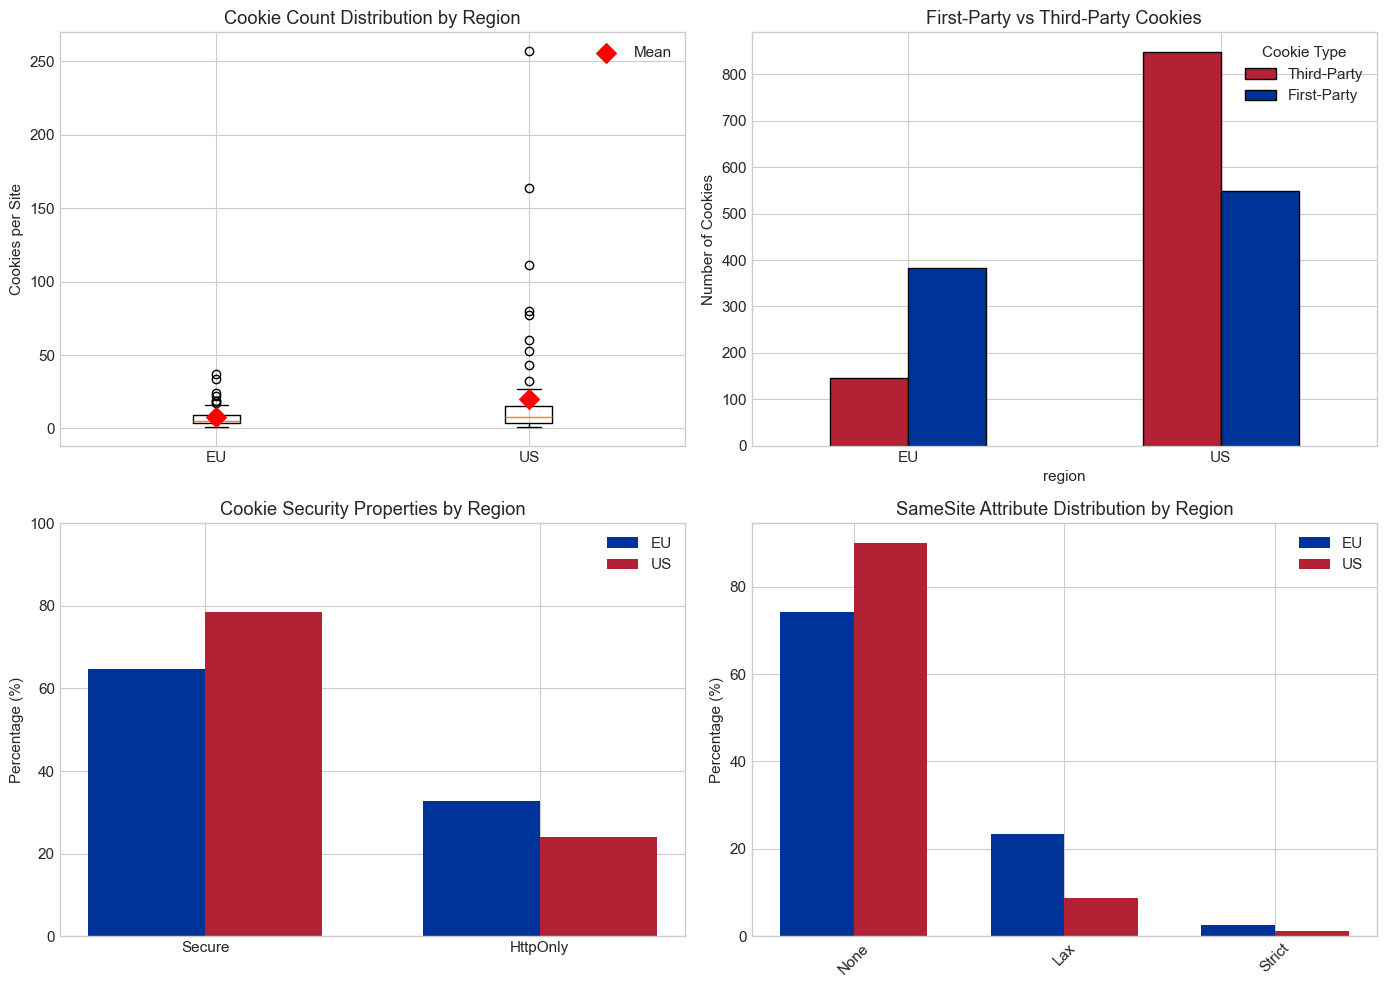


📊 Statistical Test (Cookie Count Difference):
  EU mean: 7.79, US mean: 20.23
  t-statistic: -2.559, p-value: 0.0116
  Significant difference!


In [66]:
# Visualize cookie comparison
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Average cookies per site
cookies_per_site = df_cookies.groupby(['region', 'url']).size().reset_index(name='count')
eu_counts = cookies_per_site[cookies_per_site['region'] == 'EU']['count']
us_counts = cookies_per_site[cookies_per_site['region'] == 'US']['count']

axes[0, 0].boxplot([eu_counts, us_counts], labels=['EU', 'US'])
axes[0, 0].set_ylabel('Cookies per Site')
axes[0, 0].set_title('Cookie Count Distribution by Region')

# Add mean markers
axes[0, 0].scatter([1, 2], [eu_counts.mean(), us_counts.mean()], 
                    color='red', marker='D', s=100, zorder=5, label='Mean')
axes[0, 0].legend()

# 2. First-party vs Third-party by region
party_data = df_cookies.groupby(['region', 'is_first_party']).size().unstack(fill_value=0)
party_data.columns = ['Third-Party', 'First-Party']
party_data.plot(kind='bar', ax=axes[0, 1], color=[COLORS['US'], COLORS['EU']], edgecolor='black')
axes[0, 1].set_title('First-Party vs Third-Party Cookies')
axes[0, 1].set_ylabel('Number of Cookies')
axes[0, 1].set_xticklabels(['EU', 'US'], rotation=0)
axes[0, 1].legend(title='Cookie Type')

# 3. Security properties comparison
security_eu = df_cookies[df_cookies['region'] == 'EU'][['secure', 'httpOnly']].mean() * 100
security_us = df_cookies[df_cookies['region'] == 'US'][['secure', 'httpOnly']].mean() * 100

x = np.arange(len(security_eu))
width = 0.35

bars1 = axes[1, 0].bar(x - width/2, security_eu.values, width, label='EU', color=COLORS['EU'])
bars2 = axes[1, 0].bar(x + width/2, security_us.values, width, label='US', color=COLORS['US'])
axes[1, 0].set_ylabel('Percentage (%)')
axes[1, 0].set_title('Cookie Security Properties by Region')
axes[1, 0].set_xticks(x)
axes[1, 0].set_xticklabels(['Secure', 'HttpOnly'])
axes[1, 0].legend()
axes[1, 0].set_ylim(0, 100)

# 4. SameSite comparison
samesite_eu = df_cookies[df_cookies['region'] == 'EU']['sameSite'].value_counts(normalize=True) * 100
samesite_us = df_cookies[df_cookies['region'] == 'US']['sameSite'].value_counts(normalize=True) * 100

# Align indices
all_samesite = list(set(samesite_eu.index) | set(samesite_us.index))
samesite_eu = samesite_eu.reindex(all_samesite, fill_value=0)
samesite_us = samesite_us.reindex(all_samesite, fill_value=0)

x = np.arange(len(all_samesite))
bars1 = axes[1, 1].bar(x - width/2, samesite_eu.values, width, label='EU', color=COLORS['EU'])
bars2 = axes[1, 1].bar(x + width/2, samesite_us.values, width, label='US', color=COLORS['US'])
axes[1, 1].set_ylabel('Percentage (%)')
axes[1, 1].set_title('SameSite Attribute Distribution by Region')
axes[1, 1].set_xticks(x)
axes[1, 1].set_xticklabels([str(s) if pd.notna(s) else 'Not Set' for s in all_samesite], rotation=45)
axes[1, 1].legend()

plt.tight_layout()
plt.savefig('../data/output/analysis/eu_us_cookies_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

# Statistical test for cookie counts
t_stat, p_value = stats.ttest_ind(eu_counts, us_counts)
print(f"\n📊 Statistical Test (Cookie Count Difference):")
print(f"  EU mean: {eu_counts.mean():.2f}, US mean: {us_counts.mean():.2f}")
print(f"  t-statistic: {t_stat:.3f}, p-value: {p_value:.4f}")
print(f"  {'Significant difference!' if p_value < 0.05 else 'No significant difference'}")

## 🔘 Consent Button Comparison

Compare consent interface buttons between regions.

In [67]:
# Button category comparison
button_comparison = df_buttons.groupby(['region', 'category']).size().unstack(fill_value=0)

print("🔘 Button Categories by Region")
print("=" * 60)
display(button_comparison)

# Calculate presence of Accept/Reject buttons by region
def get_button_presence(df, region):
    region_df = df[df['region'] == region]
    sites = region_df['url'].unique()
    
    has_accept = set(region_df[region_df['category'] == 'Accept']['url'].unique())
    has_reject = set(region_df[region_df['category'] == 'Reject']['url'].unique())
    
    both = has_accept & has_reject
    accept_only = has_accept - has_reject
    reject_only = has_reject - has_accept
    neither = set(sites) - has_accept - has_reject
    
    return {
        'Both Accept & Reject': len(both),
        'Accept Only (Dark Pattern)': len(accept_only),
        'Reject Only': len(reject_only),
        'Neither': len(neither)
    }

eu_presence = get_button_presence(df_buttons, 'EU')
us_presence = get_button_presence(df_buttons, 'US')

print("\n📊 Accept/Reject Button Presence:")
print("\nEU:")
for k, v in eu_presence.items():
    print(f"  {k}: {v}")
    
print("\nUS:")
for k, v in us_presence.items():
    print(f"  {k}: {v}")

🔘 Button Categories by Region


category,Accept,Other,Reject,Settings
region,,,,
EU,50,42,18,9
US,12,19,6,4



📊 Accept/Reject Button Presence:

EU:
  Both Accept & Reject: 16
  Accept Only (Dark Pattern): 13
  Reject Only: 2
  Neither: 6

US:
  Both Accept & Reject: 4
  Accept Only (Dark Pattern): 5
  Reject Only: 2
  Neither: 3


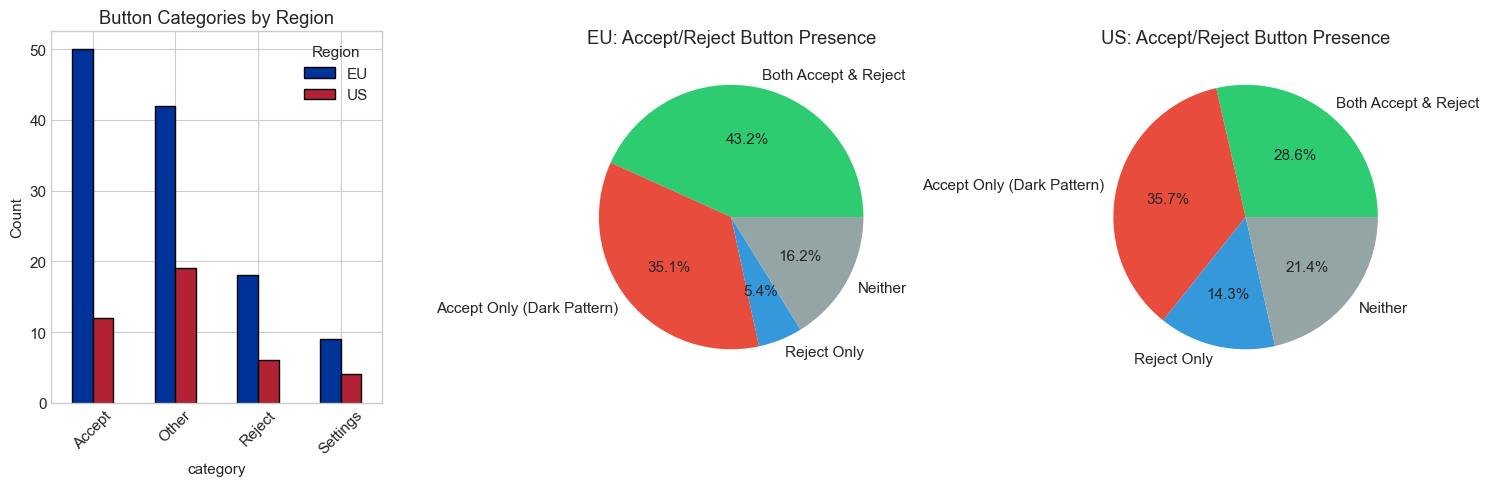


⚠️  Dark Pattern (No Reject Button) Comparison:
  EU: 35.1% of sites
  US: 35.7% of sites
  Difference: 0.6 percentage points


In [68]:
# Visualize button comparison
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# 1. Button categories by region
button_comparison.T.plot(kind='bar', ax=axes[0], color=[COLORS['EU'], COLORS['US']], edgecolor='black')
axes[0].set_title('Button Categories by Region')
axes[0].set_ylabel('Count')
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45)
axes[0].legend(title='Region')

# 2. EU Accept/Reject presence
eu_values = list(eu_presence.values())
eu_labels = list(eu_presence.keys())
colors_pie = ['#2ecc71', '#e74c3c', '#3498db', '#95a5a6']
axes[1].pie(eu_values, labels=eu_labels, autopct='%1.1f%%', colors=colors_pie)
axes[1].set_title('EU: Accept/Reject Button Presence')

# 3. US Accept/Reject presence
us_values = list(us_presence.values())
axes[2].pie(us_values, labels=eu_labels, autopct='%1.1f%%', colors=colors_pie)
axes[2].set_title('US: Accept/Reject Button Presence')

plt.tight_layout()
plt.savefig('../data/output/analysis/eu_us_buttons_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

# Dark pattern comparison
eu_dark = eu_presence['Accept Only (Dark Pattern)'] / sum(eu_presence.values()) * 100
us_dark = us_presence['Accept Only (Dark Pattern)'] / sum(us_presence.values()) * 100

print(f"\n⚠️  Dark Pattern (No Reject Button) Comparison:")
print(f"  EU: {eu_dark:.1f}% of sites")
print(f"  US: {us_dark:.1f}% of sites")
print(f"  Difference: {abs(eu_dark - us_dark):.1f} percentage points")

## 🏢 CMP Comparison

Compare Consent Management Platform usage between regions.

In [69]:
# CMP detection rates by region
cmp_detection_eu = df_cmps[df_cmps['region'] == 'EU']['cmp_detected'].mean() * 100
cmp_detection_us = df_cmps[df_cmps['region'] == 'US']['cmp_detected'].mean() * 100

print("🏢 CMP Detection Rates")
print("=" * 60)
print(f"  EU: {cmp_detection_eu:.1f}% of sites have a detected CMP")
print(f"  US: {cmp_detection_us:.1f}% of sites have a detected CMP")

# Top CMPs by region
print("\n📊 Top CMPs by Region:")

print("\nEU:")
eu_cmps = df_cmps[(df_cmps['region'] == 'EU') & (df_cmps['cmp_detected'])]['cmp_name'].value_counts().head(5)
for cmp, count in eu_cmps.items():
    print(f"  {cmp}: {count}")\

print("\nUS:")
us_cmps = df_cmps[(df_cmps['region'] == 'US') & (df_cmps['cmp_detected'])]['cmp_name'].value_counts().head(5)
for cmp, count in us_cmps.items():
    print(f"  {cmp}: {count}")

🏢 CMP Detection Rates
  EU: 67.7% of sites have a detected CMP
  US: 55.8% of sites have a detected CMP

📊 Top CMPs by Region:

EU:
  Unknown: 172

US:
  Unknown: 111


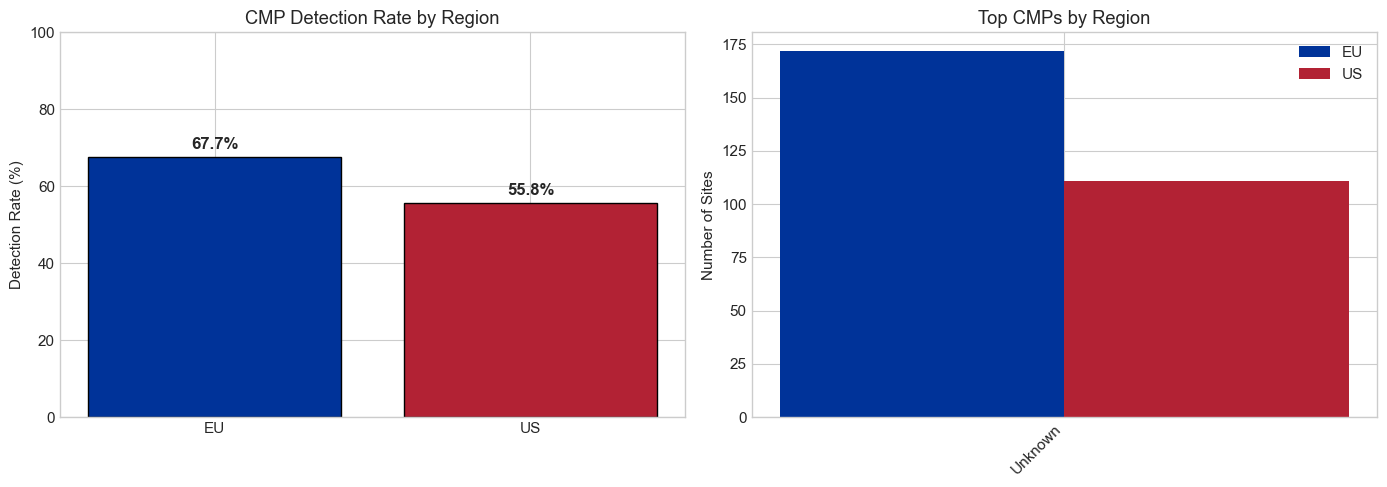

In [70]:
# Visualize CMP comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 1. CMP Detection Rate
regions = ['EU', 'US']
detection_rates = [cmp_detection_eu, cmp_detection_us]
bars = axes[0].bar(regions, detection_rates, color=[COLORS['EU'], COLORS['US']], edgecolor='black')
axes[0].set_ylabel('Detection Rate (%)')
axes[0].set_title('CMP Detection Rate by Region')
axes[0].set_ylim(0, 100)

for bar, rate in zip(bars, detection_rates):
    axes[0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 2, 
                  f'{rate:.1f}%', ha='center', fontsize=12, fontweight='bold')

# 2. Top CMPs comparison
# Get all CMPs from both regions
all_cmps = set(eu_cmps.index) | set(us_cmps.index)
eu_aligned = eu_cmps.reindex(all_cmps, fill_value=0)
us_aligned = us_cmps.reindex(all_cmps, fill_value=0)

x = np.arange(len(all_cmps))
width = 0.35

bars1 = axes[1].bar(x - width/2, eu_aligned.values, width, label='EU', color=COLORS['EU'])
bars2 = axes[1].bar(x + width/2, us_aligned.values, width, label='US', color=COLORS['US'])
axes[1].set_ylabel('Number of Sites')
axes[1].set_title('Top CMPs by Region')
axes[1].set_xticks(x)
axes[1].set_xticklabels(all_cmps, rotation=45, ha='right')
axes[1].legend()

plt.tight_layout()
plt.savefig('../data/output/analysis/eu_us_cmp_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

## 📊 Summary Dashboard

Overall comparison between EU and US cookie consent practices.

In [71]:
# Create comprehensive summary
summary_data = {
    'Metric': [
        'Sites Analyzed',
        'Total Cookies',
        'Avg Cookies/Site',
        'First-Party Cookies %',
        'CMP Detection Rate %',
        'Sites with Reject Button %',
        'Dark Pattern (No Reject) %'
    ],
    'EU': [
        len(eu_urls),
        len(df_cookies_eu),
        f"{df_cookies_eu.groupby('url').size().mean():.1f}",
        f"{df_cookies_eu['is_first_party'].mean()*100:.1f}",
        f"{cmp_detection_eu:.1f}",
        f"{(100 - eu_dark):.1f}",
        f"{eu_dark:.1f}"
    ],
    'US': [
        len(us_urls),
        len(df_cookies_us),
        f"{df_cookies_us.groupby('url').size().mean():.1f}",
        f"{df_cookies_us['is_first_party'].mean()*100:.1f}",
        f"{cmp_detection_us:.1f}",
        f"{(100 - us_dark):.1f}",
        f"{us_dark:.1f}"
    ]
}

df_summary = pd.DataFrame(summary_data)
df_summary = df_summary.set_index('Metric')

print("📊 EU vs US COMPARISON SUMMARY")
print("=" * 60)
display(df_summary)

# Export summary
output_dir = Path('../data/output/analysis')
output_dir.mkdir(parents=True, exist_ok=True)
df_summary.to_csv(output_dir / 'eu_us_comparison_summary.csv')
print(f"\n✅ Summary exported to {output_dir / 'eu_us_comparison_summary.csv'}")

📊 EU vs US COMPARISON SUMMARY


,EU,US
Metric,,
Sites Analyzed,100,100
Total Cookies,530,1396
Avg Cookies/Site,7.8,20.2
First-Party Cookies %,72.3,39.3
CMP Detection Rate %,67.7,55.8
Sites with Reject Button %,64.9,64.3
Dark Pattern (No Reject) %,35.1,35.7



✅ Summary exported to ..\data\output\analysis\eu_us_comparison_summary.csv


## 🔬 Statistical Analysis

Perform statistical tests to determine if differences are significant.

In [72]:
# Statistical tests
print("🔬 STATISTICAL ANALYSIS")
print("=" * 60)

# 1. Cookie count difference (t-test)
eu_cookie_counts = df_cookies_eu.groupby('url').size()
us_cookie_counts = df_cookies_us.groupby('url').size()

t_stat, p_value = stats.ttest_ind(eu_cookie_counts, us_cookie_counts)
print(f"\n1️⃣  Cookie Count Comparison (Independent t-test)")
print(f"   EU mean: {eu_cookie_counts.mean():.2f} ± {eu_cookie_counts.std():.2f}")
print(f"   US mean: {us_cookie_counts.mean():.2f} ± {us_cookie_counts.std():.2f}")
print(f"   t-statistic: {t_stat:.3f}")
print(f"   p-value: {p_value:.4f}")
print(f"   Result: {'Significant difference (p < 0.05)' if p_value < 0.05 else 'No significant difference'}")

# 2. CMP detection rate (Chi-squared test)
eu_cmp_yes = df_cmps_eu['cmp_detected'].sum()
eu_cmp_no = len(df_cmps_eu) - eu_cmp_yes
us_cmp_yes = df_cmps_us['cmp_detected'].sum()
us_cmp_no = len(df_cmps_us) - us_cmp_yes

contingency = [[eu_cmp_yes, eu_cmp_no], [us_cmp_yes, us_cmp_no]]
chi2, p_value, dof, expected = stats.chi2_contingency(contingency)

print(f"\n2️⃣  CMP Detection Rate (Chi-squared test)")
print(f"   EU: {eu_cmp_yes} detected, {eu_cmp_no} not detected")
print(f"   US: {us_cmp_yes} detected, {us_cmp_no} not detected")
print(f"   Chi-squared: {chi2:.3f}")
print(f"   p-value: {p_value:.4f}")
print(f"   Result: {'Significant difference (p < 0.05)' if p_value < 0.05 else 'No significant difference'}")

# 3. Dark pattern rate (Chi-squared test)
eu_dark_count = eu_presence['Accept Only (Dark Pattern)']
eu_not_dark = sum(eu_presence.values()) - eu_dark_count
us_dark_count = us_presence['Accept Only (Dark Pattern)']
us_not_dark = sum(us_presence.values()) - us_dark_count

contingency = [[eu_dark_count, eu_not_dark], [us_dark_count, us_not_dark]]
chi2, p_value, dof, expected = stats.chi2_contingency(contingency)

print(f"\n3️⃣  Dark Pattern Rate (Chi-squared test)")
print(f"   EU: {eu_dark_count} dark pattern, {eu_not_dark} not dark pattern")
print(f"   US: {us_dark_count} dark pattern, {us_not_dark} not dark pattern")
print(f"   Chi-squared: {chi2:.3f}")
print(f"   p-value: {p_value:.4f}")
print(f"   Result: {'Significant difference (p < 0.05)' if p_value < 0.05 else 'No significant difference'}")

🔬 STATISTICAL ANALYSIS

1️⃣  Cookie Count Comparison (Independent t-test)
   EU mean: 7.79 ± 7.19
   US mean: 20.23 ± 39.44
   t-statistic: -2.559
   p-value: 0.0116
   Result: Significant difference (p < 0.05)

2️⃣  CMP Detection Rate (Chi-squared test)
   EU: 172 detected, 82 not detected
   US: 111 detected, 88 not detected
   Chi-squared: 6.283
   p-value: 0.0122
   Result: Significant difference (p < 0.05)

3️⃣  Dark Pattern Rate (Chi-squared test)
   EU: 13 dark pattern, 24 not dark pattern
   US: 5 dark pattern, 9 not dark pattern
   Chi-squared: 0.000
   p-value: 1.0000
   Result: No significant difference


## 🍪🚫 Cookies Without CMPs Analysis

Analyze websites that have cookies but **no consent management platform (CMP/banner)** detected.
This reveals sites that may be setting cookies without proper consent mechanisms.

In [73]:
# ============================================================
# COOKIES WITHOUT CMP (CONSENT BANNER) ANALYSIS
# ============================================================

# Identify sites with cookies but NO CMP detected
def get_sites_with_cookies_no_cmp(df_cookies, df_cmps, region):
    """Find websites that have cookies but no CMP detected."""
    # Sites with cookies
    sites_with_cookies = set(df_cookies[df_cookies['region'] == region]['url'].unique())
    
    # Sites with CMP detected
    sites_with_cmp = set(df_cmps[(df_cmps['region'] == region) & (df_cmps['cmp_detected'] == True)]['url'].unique())
    
    # Sites with cookies but NO CMP
    sites_cookies_no_cmp = sites_with_cookies - sites_with_cmp
    
    return sites_cookies_no_cmp

eu_cookies_no_cmp = get_sites_with_cookies_no_cmp(df_cookies, df_cmps, 'EU')
us_cookies_no_cmp = get_sites_with_cookies_no_cmp(df_cookies, df_cmps, 'US')

print("=" * 60)
print("🍪🚫 WEBSITES WITH COOKIES BUT NO CMP (BANNER)")
print("=" * 60)

print(f"\n📊 All Cookies (First-Party + Third-Party):")
print(f"   EU: {len(eu_cookies_no_cmp)} sites have cookies without CMP")
print(f"   US: {len(us_cookies_no_cmp)} sites have cookies without CMP")

# Now for THIRD-PARTY cookies specifically
def get_sites_with_third_party_cookies_no_cmp(df_cookies, df_cmps, region):
    """Find websites that have THIRD-PARTY cookies but no CMP detected."""
    # Sites with third-party cookies
    third_party_cookies = df_cookies[(df_cookies['region'] == region) & (df_cookies['is_first_party'] == False)]
    sites_with_3p_cookies = set(third_party_cookies['url'].unique())
    
    # Sites with CMP detected
    sites_with_cmp = set(df_cmps[(df_cmps['region'] == region) & (df_cmps['cmp_detected'] == True)]['url'].unique())
    
    # Sites with third-party cookies but NO CMP
    sites_3p_cookies_no_cmp = sites_with_3p_cookies - sites_with_cmp
    
    return sites_3p_cookies_no_cmp

eu_3p_cookies_no_cmp = get_sites_with_third_party_cookies_no_cmp(df_cookies, df_cmps, 'EU')
us_3p_cookies_no_cmp = get_sites_with_third_party_cookies_no_cmp(df_cookies, df_cmps, 'US')

print(f"\n📊 Third-Party Cookies Only:")
print(f"   EU: {len(eu_3p_cookies_no_cmp)} sites have 3rd-party cookies without CMP")
print(f"   US: {len(us_3p_cookies_no_cmp)} sites have 3rd-party cookies without CMP")

# Calculate percentages
total_eu_sites = len(df_cmps[df_cmps['region'] == 'EU']['url'].unique())
total_us_sites = len(df_cmps[df_cmps['region'] == 'US']['url'].unique())

print(f"\n📈 Percentage of Sites Without CMP (but have cookies):")
print(f"   EU: {len(eu_cookies_no_cmp)/total_eu_sites*100:.1f}% (all cookies)")
print(f"   US: {len(us_cookies_no_cmp)/total_us_sites*100:.1f}% (all cookies)")
print(f"   EU: {len(eu_3p_cookies_no_cmp)/total_eu_sites*100:.1f}% (3rd-party cookies)")
print(f"   US: {len(us_3p_cookies_no_cmp)/total_us_sites*100:.1f}% (3rd-party cookies)")

🍪🚫 WEBSITES WITH COOKIES BUT NO CMP (BANNER)

📊 All Cookies (First-Party + Third-Party):
   EU: 50 sites have cookies without CMP
   US: 57 sites have cookies without CMP

📊 Third-Party Cookies Only:
   EU: 20 sites have 3rd-party cookies without CMP
   US: 29 sites have 3rd-party cookies without CMP

📈 Percentage of Sites Without CMP (but have cookies):
   EU: 50.0% (all cookies)
   US: 57.0% (all cookies)
   EU: 20.0% (3rd-party cookies)
   US: 29.0% (3rd-party cookies)


C:\Users\sahin\AppData\Local\Temp\ipykernel_11652\1219349614.py:43: UserWarning: Glyph 127850 (\N{COOKIE}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\sahin\AppData\Local\Temp\ipykernel_11652\1219349614.py:43: UserWarning: Glyph 128274 (\N{LOCK}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\sahin\AppData\Local\Temp\ipykernel_11652\1219349614.py:44: UserWarning: Glyph 127850 (\N{COOKIE}) missing from font(s) Arial.
  plt.savefig(output_dir / 'cookies_without_cmp_comparison.png', dpi=150, bbox_inches='tight')
C:\Users\sahin\AppData\Local\Temp\ipykernel_11652\1219349614.py:44: UserWarning: Glyph 128274 (\N{LOCK}) missing from font(s) Arial.
  plt.savefig(output_dir / 'cookies_without_cmp_comparison.png', dpi=150, bbox_inches='tight')
C:\Users\sahin\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 127850 (\N{COOKIE}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\sahin\AppData\Roamin

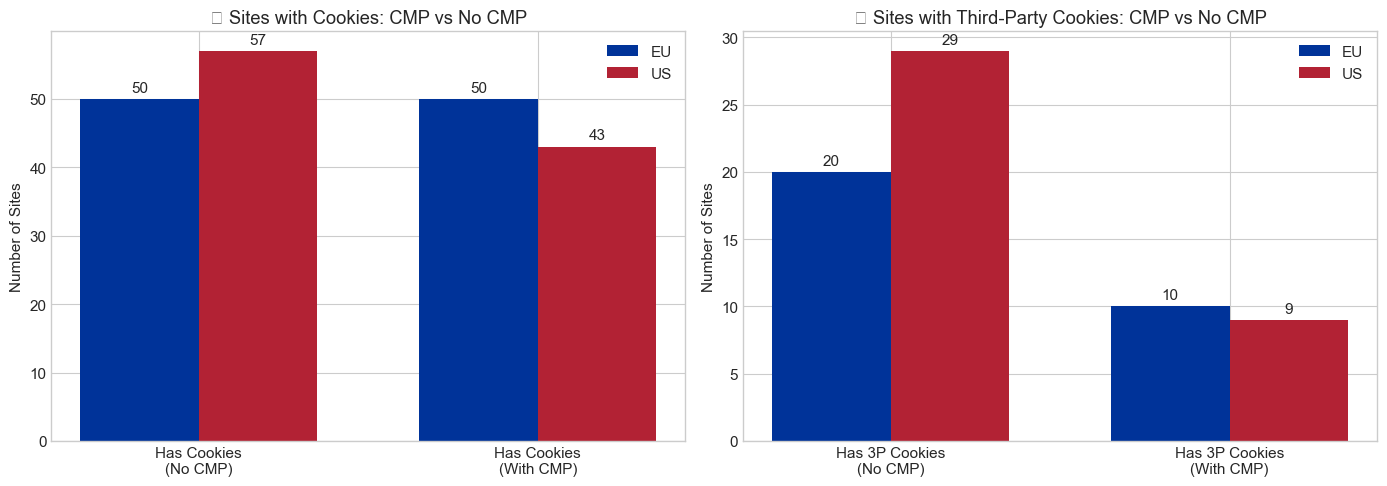


💾 Chart saved to: data/output/analysis/cookies_without_cmp_comparison.png


In [74]:
# Visualization: Cookies without CMP comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Chart 1: All cookies without CMP
categories = ['Has Cookies\n(No CMP)', 'Has Cookies\n(With CMP)']
eu_vals = [len(eu_cookies_no_cmp), total_eu_sites - len(eu_cookies_no_cmp)]
us_vals = [len(us_cookies_no_cmp), total_us_sites - len(us_cookies_no_cmp)]

x = np.arange(len(categories))
width = 0.35

bars1 = axes[0].bar(x - width/2, eu_vals, width, label='EU', color=COLORS['EU'])
bars2 = axes[0].bar(x + width/2, us_vals, width, label='US', color=COLORS['US'])

axes[0].set_ylabel('Number of Sites')
axes[0].set_title('🍪 Sites with Cookies: CMP vs No CMP')
axes[0].set_xticks(x)
axes[0].set_xticklabels(categories)
axes[0].legend()
axes[0].bar_label(bars1, padding=3)
axes[0].bar_label(bars2, padding=3)

# Chart 2: Third-party cookies without CMP
categories_3p = ['Has 3P Cookies\n(No CMP)', 'Has 3P Cookies\n(With CMP)']
# Calculate sites with 3p cookies AND cmp
eu_3p_with_cmp = len(set(df_cookies[(df_cookies['region'] == 'EU') & (df_cookies['is_first_party'] == False)]['url'].unique()) - eu_3p_cookies_no_cmp)
us_3p_with_cmp = len(set(df_cookies[(df_cookies['region'] == 'US') & (df_cookies['is_first_party'] == False)]['url'].unique()) - us_3p_cookies_no_cmp)

eu_vals_3p = [len(eu_3p_cookies_no_cmp), eu_3p_with_cmp]
us_vals_3p = [len(us_3p_cookies_no_cmp), us_3p_with_cmp]

bars3 = axes[1].bar(x - width/2, eu_vals_3p, width, label='EU', color=COLORS['EU'])
bars4 = axes[1].bar(x + width/2, us_vals_3p, width, label='US', color=COLORS['US'])

axes[1].set_ylabel('Number of Sites')
axes[1].set_title('🔒 Sites with Third-Party Cookies: CMP vs No CMP')
axes[1].set_xticks(x)
axes[1].set_xticklabels(categories_3p)
axes[1].legend()
axes[1].bar_label(bars3, padding=3)
axes[1].bar_label(bars4, padding=3)

plt.tight_layout()
plt.savefig(output_dir / 'cookies_without_cmp_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n💾 Chart saved to: data/output/analysis/cookies_without_cmp_comparison.png")

## 🔍 Per-Website Cookie Difference Analysis

Compare cookie counts between EU and US for **each individual website**.
Identify which websites show the **highest** and **lowest** differences in cookie behavior.

In [75]:
# ============================================================
# PER-WEBSITE COOKIE COMPARISON (EU vs US)
# ============================================================

# Count cookies per website per region
eu_cookie_counts_per_site = df_cookies[df_cookies['region'] == 'EU'].groupby('url').size().reset_index(name='eu_cookies')
us_cookie_counts_per_site = df_cookies[df_cookies['region'] == 'US'].groupby('url').size().reset_index(name='us_cookies')

# Merge on URL (only common URLs)
website_comparison = pd.merge(eu_cookie_counts_per_site, us_cookie_counts_per_site, on='url', how='inner')

# Calculate difference (EU - US: positive means EU has more cookies)
website_comparison['cookie_difference'] = website_comparison['eu_cookies'] - website_comparison['us_cookies']
website_comparison['abs_difference'] = website_comparison['cookie_difference'].abs()

# Sort by absolute difference
website_comparison_sorted = website_comparison.sort_values('abs_difference', ascending=False)

print("=" * 70)
print("🔍 PER-WEBSITE COOKIE DIFFERENCE (EU vs US)")
print("=" * 70)

print(f"\n📊 Analyzed {len(website_comparison)} websites present in both datasets")
print(f"   Average difference: {website_comparison['cookie_difference'].mean():.2f} cookies")
print(f"   Median difference: {website_comparison['cookie_difference'].median():.2f} cookies")

# Top 10 HIGHEST differences
print("\n" + "=" * 70)
print("📈 TOP 10 WEBSITES WITH HIGHEST COOKIE DIFFERENCE")
print("=" * 70)
print("\n   (Positive = EU has MORE cookies, Negative = US has MORE cookies)\n")

top_10_diff = website_comparison_sorted.head(10)
for i, row in top_10_diff.iterrows():
    direction = "EU > US" if row['cookie_difference'] > 0 else "US > EU"
    print(f"   {row['url']}")
    print(f"      EU: {row['eu_cookies']} cookies | US: {row['us_cookies']} cookies | Diff: {row['cookie_difference']:+d} ({direction})")
    print()

# Top 10 LOWEST differences (most similar)
print("=" * 70)
print("📉 TOP 10 WEBSITES WITH LOWEST COOKIE DIFFERENCE (Most Similar)")
print("=" * 70)

bottom_10_diff = website_comparison_sorted.tail(10)
for i, row in bottom_10_diff.iterrows():
    print(f"   {row['url']}")
    print(f"      EU: {row['eu_cookies']} cookies | US: {row['us_cookies']} cookies | Diff: {row['cookie_difference']:+d}")
    print()

🔍 PER-WEBSITE COOKIE DIFFERENCE (EU vs US)

📊 Analyzed 67 websites present in both datasets
   Average difference: -12.87 cookies
   Median difference: -2.00 cookies

📈 TOP 10 WEBSITES WITH HIGHEST COOKIE DIFFERENCE

   (Positive = EU has MORE cookies, Negative = US has MORE cookies)

   https://imdb.com
      EU: 5 cookies | US: 257 cookies | Diff: -252 (US > EU)

   https://nytimes.com
      EU: 19 cookies | US: 164 cookies | Diff: -145 (US > EU)

   https://forbes.com
      EU: 5 cookies | US: 111 cookies | Diff: -106 (US > EU)

   https://windows.com
      EU: 8 cookies | US: 77 cookies | Diff: -69 (US > EU)

   https://f5.com
      EU: 16 cookies | US: 80 cookies | Diff: -64 (US > EU)

   https://taboola.com
      EU: 22 cookies | US: 60 cookies | Diff: -38 (US > EU)

   https://office365.com
      EU: 24 cookies | US: 43 cookies | Diff: -19 (US > EU)

   https://soundcloud.com
      EU: 9 cookies | US: 27 cookies | Diff: -18 (US > EU)

   https://digicert.com
      EU: 37 cookies

C:\Users\sahin\AppData\Local\Temp\ipykernel_11652\1462951639.py:30: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\sahin\AppData\Local\Temp\ipykernel_11652\1462951639.py:30: UserWarning: Glyph 127942 (\N{TROPHY}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\sahin\AppData\Local\Temp\ipykernel_11652\1462951639.py:31: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Arial.
  plt.savefig(output_dir / 'per_website_cookie_difference.png', dpi=150, bbox_inches='tight')
C:\Users\sahin\AppData\Local\Temp\ipykernel_11652\1462951639.py:31: UserWarning: Glyph 127942 (\N{TROPHY}) missing from font(s) Arial.
  plt.savefig(output_dir / 'per_website_cookie_difference.png', dpi=150, bbox_inches='tight')
C:\Users\sahin\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\sahin\App

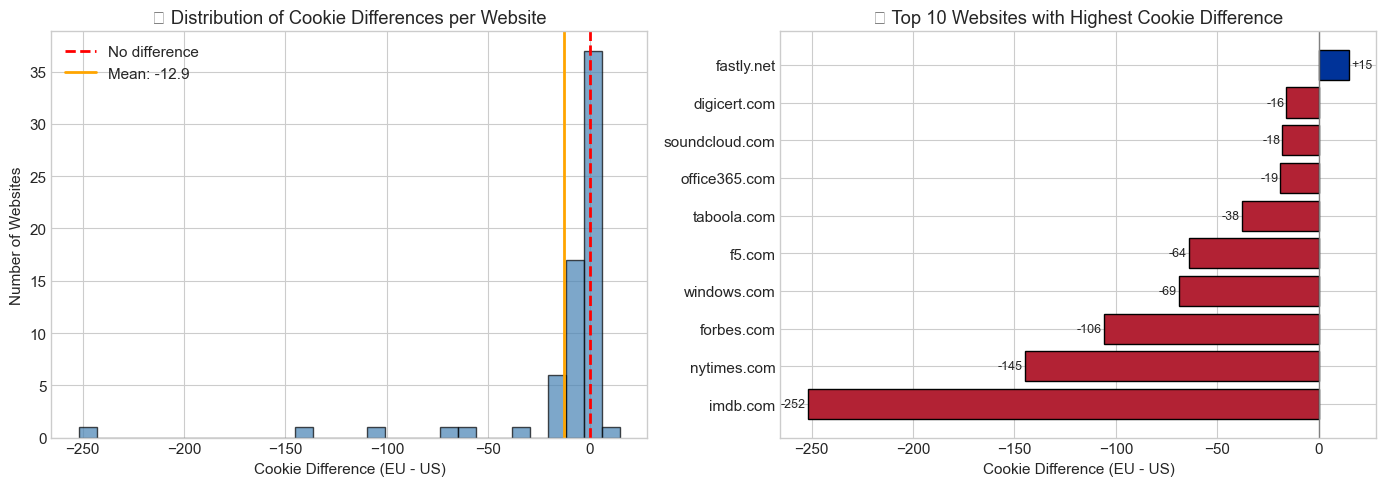


💾 Chart saved to: data/output/analysis/per_website_cookie_difference.png


In [76]:
# Visualization: Distribution of cookie differences
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histogram of differences
axes[0].hist(website_comparison['cookie_difference'], bins=30, color='steelblue', edgecolor='black', alpha=0.7)
axes[0].axvline(x=0, color='red', linestyle='--', linewidth=2, label='No difference')
axes[0].axvline(x=website_comparison['cookie_difference'].mean(), color='orange', linestyle='-', linewidth=2, label=f'Mean: {website_comparison["cookie_difference"].mean():.1f}')
axes[0].set_xlabel('Cookie Difference (EU - US)')
axes[0].set_ylabel('Number of Websites')
axes[0].set_title('📊 Distribution of Cookie Differences per Website')
axes[0].legend()

# Bar chart: Top 10 differences
top_10 = website_comparison_sorted.head(10)
# Extract domain for readability
top_10_domains = [url.replace('https://', '').replace('http://', '').replace('www.', '').split('/')[0][:20] for url in top_10['url']]
colors_bar = [COLORS['EU'] if d > 0 else COLORS['US'] for d in top_10['cookie_difference']]

bars = axes[1].barh(range(len(top_10)), top_10['cookie_difference'], color=colors_bar, edgecolor='black')
axes[1].set_yticks(range(len(top_10)))
axes[1].set_yticklabels(top_10_domains)
axes[1].set_xlabel('Cookie Difference (EU - US)')
axes[1].set_title('🏆 Top 10 Websites with Highest Cookie Difference')
axes[1].axvline(x=0, color='gray', linestyle='-', linewidth=1)

# Add value labels
for i, (bar, val) in enumerate(zip(bars, top_10['cookie_difference'])):
    axes[1].text(val + (1 if val > 0 else -1), i, f'{val:+d}', va='center', ha='left' if val > 0 else 'right', fontsize=9)

plt.tight_layout()
plt.savefig(output_dir / 'per_website_cookie_difference.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n💾 Chart saved to: data/output/analysis/per_website_cookie_difference.png")

## 🍪 Cookie Type Difference Analysis

Compare which **types** of cookies differ most between EU and US:
- First-Party vs Third-Party
- Secure vs Non-Secure
- HttpOnly vs Non-HttpOnly
- Session vs Persistent
- SameSite attributes

In [77]:
# ============================================================
# COOKIE TYPE DIFFERENCE ANALYSIS
# ============================================================

# Count cookies by type for each region
def count_cookie_types(df, region):
    """Count different cookie types for a region."""
    region_df = df[df['region'] == region]
    
    return {
        'Total': len(region_df),
        'First-Party': len(region_df[region_df['is_first_party'] == True]),
        'Third-Party': len(region_df[region_df['is_first_party'] == False]),
        'Secure': len(region_df[region_df['secure'] == True]),
        'Non-Secure': len(region_df[region_df['secure'] == False]),
        'HttpOnly': len(region_df[region_df['httpOnly'] == True]),
        'Non-HttpOnly': len(region_df[region_df['httpOnly'] == False]),
        'Session': len(region_df[region_df['session'] == True]),
        'Persistent': len(region_df[region_df['session'] == False]),
        'SameSite=Strict': len(region_df[region_df['sameSite'] == 'Strict']),
        'SameSite=Lax': len(region_df[region_df['sameSite'] == 'Lax']),
        'SameSite=None': len(region_df[region_df['sameSite'] == 'None']),
        'SameSite=Unset': len(region_df[region_df['sameSite'].isna()]),
    }

eu_types = count_cookie_types(df_cookies, 'EU')
us_types = count_cookie_types(df_cookies, 'US')

# Calculate differences
print("=" * 70)
print("🍪 COOKIE TYPE COMPARISON: EU vs US")
print("=" * 70)

type_comparison_data = []
for cookie_type in eu_types.keys():
    eu_count = eu_types[cookie_type]
    us_count = us_types[cookie_type]
    diff = eu_count - us_count
    pct_diff = ((eu_count - us_count) / us_count * 100) if us_count > 0 else 0
    
    type_comparison_data.append({
        'Cookie Type': cookie_type,
        'EU Count': eu_count,
        'US Count': us_count,
        'Difference': diff,
        '% Difference': pct_diff
    })

type_comparison_df = pd.DataFrame(type_comparison_data)
type_comparison_df = type_comparison_df.sort_values('Difference', key=abs, ascending=False)

print("\n   Cookie Type          |    EU    |    US    |   Diff   |  % Diff")
print("   " + "-" * 65)
for _, row in type_comparison_df.iterrows():
    print(f"   {row['Cookie Type']:<20} | {row['EU Count']:>7} | {row['US Count']:>7} | {row['Difference']:>+7} | {row['% Difference']:>+7.1f}%")

# Highlight the most different types
print("\n" + "=" * 70)
print("📊 MOST DIFFERENT COOKIE TYPES (by absolute count)")
print("=" * 70)
top_diff_types = type_comparison_df[type_comparison_df['Cookie Type'] != 'Total'].head(5)
for _, row in top_diff_types.iterrows():
    direction = "MORE in EU" if row['Difference'] > 0 else "MORE in US"
    print(f"\n   🔸 {row['Cookie Type']}: {abs(row['Difference'])} {direction}")
    print(f"      EU: {row['EU Count']} | US: {row['US Count']} ({row['% Difference']:+.1f}%)")

🍪 COOKIE TYPE COMPARISON: EU vs US

   Cookie Type          |    EU    |    US    |   Diff   |  % Diff
   -----------------------------------------------------------------
   Total                |     530 |    1396 |    -866 |   -62.0%
   Persistent           |     424 |    1249 |    -825 |   -66.1%
   Secure               |     343 |    1096 |    -753 |   -68.7%
   SameSite=None        |     235 |     966 |    -731 |   -75.7%
   Non-HttpOnly         |     357 |    1060 |    -703 |   -66.3%
   Third-Party          |     147 |     848 |    -701 |   -82.7%
   First-Party          |     383 |     548 |    -165 |   -30.1%
   HttpOnly             |     173 |     336 |    -163 |   -48.5%
   Non-Secure           |     187 |     300 |    -113 |   -37.7%
   SameSite=Unset       |     213 |     323 |    -110 |   -34.1%
   Session              |     106 |     147 |     -41 |   -27.9%
   SameSite=Lax         |      74 |      94 |     -20 |   -21.3%
   SameSite=Strict      |       8 |      13 |   

C:\Users\sahin\AppData\Local\Temp\ipykernel_11652\3757060164.py:50: UserWarning: Glyph 127850 (\N{COOKIE}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\sahin\AppData\Local\Temp\ipykernel_11652\3757060164.py:50: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\sahin\AppData\Local\Temp\ipykernel_11652\3757060164.py:51: UserWarning: Glyph 127850 (\N{COOKIE}) missing from font(s) Arial.
  plt.savefig(output_dir / 'cookie_type_differences.png', dpi=150, bbox_inches='tight')
C:\Users\sahin\AppData\Local\Temp\ipykernel_11652\3757060164.py:51: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Arial.
  plt.savefig(output_dir / 'cookie_type_differences.png', dpi=150, bbox_inches='tight')
C:\Users\sahin\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 127850 (\N{COOKIE}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\sahin\AppData\Roaming\Py

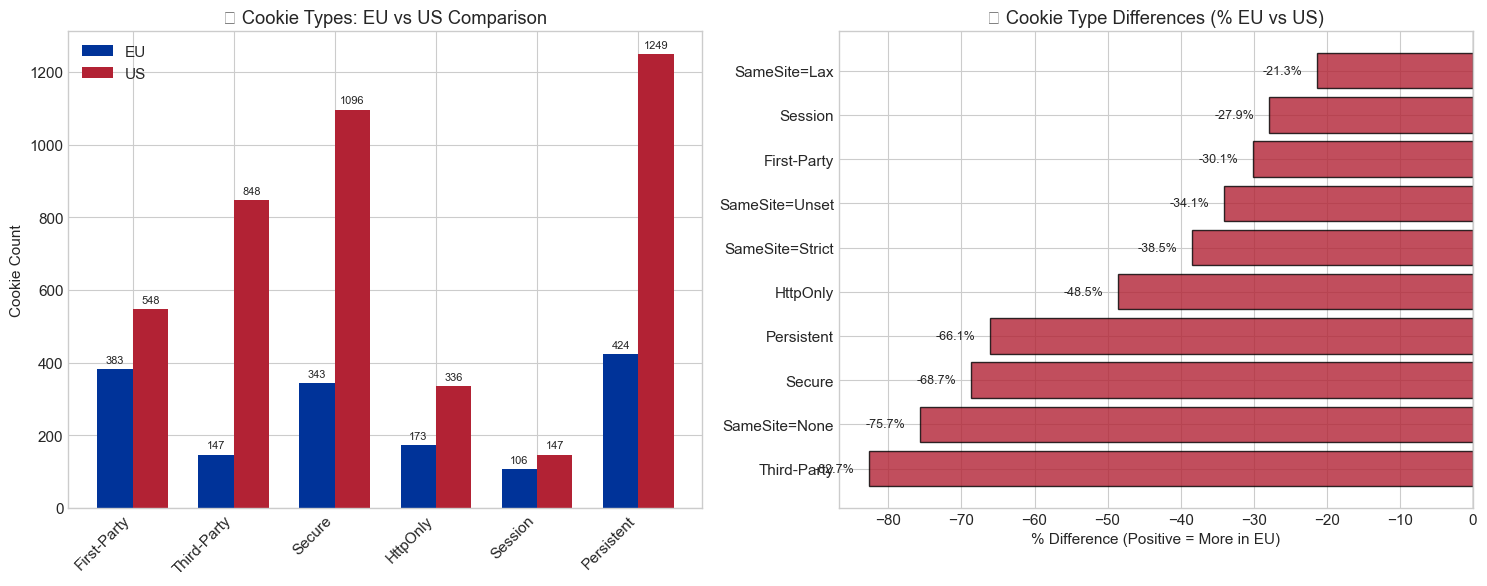


💾 Chart saved to: data/output/analysis/cookie_type_differences.png


In [78]:
# Visualization: Cookie Type Differences
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Chart 1: Cookie types comparison (bar chart)
key_types = ['First-Party', 'Third-Party', 'Secure', 'HttpOnly', 'Session', 'Persistent']
key_type_df = type_comparison_df[type_comparison_df['Cookie Type'].isin(key_types)]

x = np.arange(len(key_types))
width = 0.35

eu_vals = [eu_types[t] for t in key_types]
us_vals = [us_types[t] for t in key_types]

bars1 = axes[0].bar(x - width/2, eu_vals, width, label='EU', color=COLORS['EU'])
bars2 = axes[0].bar(x + width/2, us_vals, width, label='US', color=COLORS['US'])

axes[0].set_ylabel('Cookie Count')
axes[0].set_title('🍪 Cookie Types: EU vs US Comparison')
axes[0].set_xticks(x)
axes[0].set_xticklabels(key_types, rotation=45, ha='right')
axes[0].legend()

# Add value labels
for bar in bars1:
    height = bar.get_height()
    axes[0].annotate(f'{int(height)}', xy=(bar.get_x() + bar.get_width()/2, height),
                     xytext=(0, 3), textcoords="offset points", ha='center', va='bottom', fontsize=8)
for bar in bars2:
    height = bar.get_height()
    axes[0].annotate(f'{int(height)}', xy=(bar.get_x() + bar.get_width()/2, height),
                     xytext=(0, 3), textcoords="offset points", ha='center', va='bottom', fontsize=8)

# Chart 2: Percentage difference (horizontal bar)
exclude_types = ['Total', 'Non-Secure', 'Non-HttpOnly']
pct_diff_df = type_comparison_df[~type_comparison_df['Cookie Type'].isin(exclude_types)].copy()
pct_diff_df = pct_diff_df.sort_values('% Difference')

colors_pct = [COLORS['EU'] if d > 0 else COLORS['US'] for d in pct_diff_df['% Difference']]

bars_pct = axes[1].barh(pct_diff_df['Cookie Type'], pct_diff_df['% Difference'], color=colors_pct, edgecolor='black', alpha=0.8)
axes[1].axvline(x=0, color='gray', linestyle='-', linewidth=1)
axes[1].set_xlabel('% Difference (Positive = More in EU)')
axes[1].set_title('📊 Cookie Type Differences (% EU vs US)')

# Add value labels
for bar, val in zip(bars_pct, pct_diff_df['% Difference']):
    axes[1].text(val + (2 if val > 0 else -2), bar.get_y() + bar.get_height()/2, 
                 f'{val:+.1f}%', va='center', ha='left' if val > 0 else 'right', fontsize=9)

plt.tight_layout()
plt.savefig(output_dir / 'cookie_type_differences.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n💾 Chart saved to: data/output/analysis/cookie_type_differences.png")

In [79]:
# ============================================================
# SUMMARY: KEY FINDINGS
# ============================================================

print("=" * 70)
print("📋 SUMMARY: KEY FINDINGS")
print("=" * 70)

# Calculate key metrics
eu_avg_cookies = df_cookies[df_cookies['region'] == 'EU'].groupby('url').size().mean()
us_avg_cookies = df_cookies[df_cookies['region'] == 'US'].groupby('url').size().mean()

eu_3p_pct = len(df_cookies[(df_cookies['region'] == 'EU') & (df_cookies['is_first_party'] == False)]) / len(df_cookies[df_cookies['region'] == 'EU']) * 100
us_3p_pct = len(df_cookies[(df_cookies['region'] == 'US') & (df_cookies['is_first_party'] == False)]) / len(df_cookies[df_cookies['region'] == 'US']) * 100

print(f"""
🔹 COOKIES WITHOUT CMP (BANNER):
   • EU: {len(eu_cookies_no_cmp)} sites ({len(eu_cookies_no_cmp)/total_eu_sites*100:.1f}%) have cookies but no CMP
   • US: {len(us_cookies_no_cmp)} sites ({len(us_cookies_no_cmp)/total_us_sites*100:.1f}%) have cookies but no CMP
   • For 3rd-party cookies: EU {len(eu_3p_cookies_no_cmp)} sites, US {len(us_3p_cookies_no_cmp)} sites

🔹 PER-WEBSITE DIFFERENCES:
   • {len(website_comparison)} websites analyzed in both regions
   • Average difference: {website_comparison['cookie_difference'].mean():.2f} cookies
   • Website with HIGHEST difference: {website_comparison_sorted.iloc[0]['url'][:50]}...
     (EU: {website_comparison_sorted.iloc[0]['eu_cookies']}, US: {website_comparison_sorted.iloc[0]['us_cookies']})

🔹 COOKIE TYPE DIFFERENCES:
   • Third-Party cookies: EU {eu_3p_pct:.1f}% vs US {us_3p_pct:.1f}%
   • Most different type: {type_comparison_df.iloc[1]['Cookie Type']} 
     (Diff: {type_comparison_df.iloc[1]['Difference']:+d}, {type_comparison_df.iloc[1]['% Difference']:+.1f}%)

🔹 REGIONAL COOKIE BEHAVIOR:
   • EU average: {eu_avg_cookies:.1f} cookies per site
   • US average: {us_avg_cookies:.1f} cookies per site
   • {"EU sites set more cookies on average" if eu_avg_cookies > us_avg_cookies else "US sites set more cookies on average"}
""")

📋 SUMMARY: KEY FINDINGS

🔹 COOKIES WITHOUT CMP (BANNER):
   • EU: 50 sites (50.0%) have cookies but no CMP
   • US: 57 sites (57.0%) have cookies but no CMP
   • For 3rd-party cookies: EU 20 sites, US 29 sites

🔹 PER-WEBSITE DIFFERENCES:
   • 67 websites analyzed in both regions
   • Average difference: -12.87 cookies
   • Website with HIGHEST difference: https://imdb.com...
     (EU: 5, US: 257)

🔹 COOKIE TYPE DIFFERENCES:
   • Third-Party cookies: EU 27.7% vs US 60.7%
   • Most different type: Persistent 
     (Diff: -825, -66.1%)

🔹 REGIONAL COOKIE BEHAVIOR:
   • EU average: 7.8 cookies per site
   • US average: 20.2 cookies per site
   • US sites set more cookies on average



## 📝 Conclusions

Based on the analysis above, summarize the key differences between EU and US cookie consent practices.

### Key Findings:
1. **Cookie Counts**: [Fill in based on results]
2. **CMP Usage**: [Fill in based on results]
3. **Dark Patterns**: [Fill in based on results]
4. **Compliance**: [Fill in based on results]

### Implications:
- Do websites adapt their consent practices based on user location?
- Is GDPR compliance limited to EU users or applied globally?
- What recommendations can be made for improving consent practices?